In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchview import draw_graph  # attempts to visualize computational graphs
import matplotlib.pyplot as plt
import ffmpeg_quality_metrics as ffqm  # for VMAF calculation
from PIL import Image
import matplotlib.image as mpimg
import cv2
import os
import random
import subprocess
import json
import numpy as np
import re   # för reguljära uttryck
import csv
from collections import defaultdict
import pandas as pd
import tqdm
# from pytorch_lightning import Trainer
# from pytorch_lightning.callbacks import LearningRateLogger
# from torch_lr_finder import LRFinder

import warnings
warnings.filterwarnings('ignore')

# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


sista-dansen.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/sista-dansen.mp4
1628
printing frame number: 772


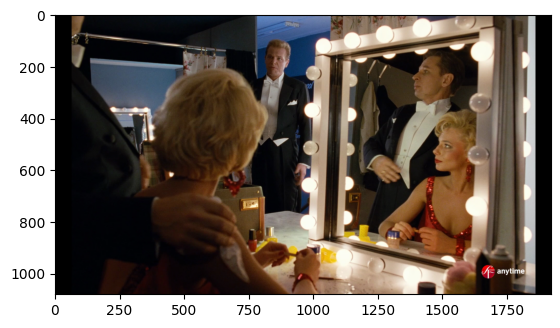

In [6]:
# läs in data

train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train"
random_video = random.choice(os.listdir(train))
print(random_video)

video_path = os.path.join(train, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000) # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # avoid frame becoming blue

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()


fading-gigolo.mp4
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test/fading-gigolo.mp4
3665
printing frame number: 1606


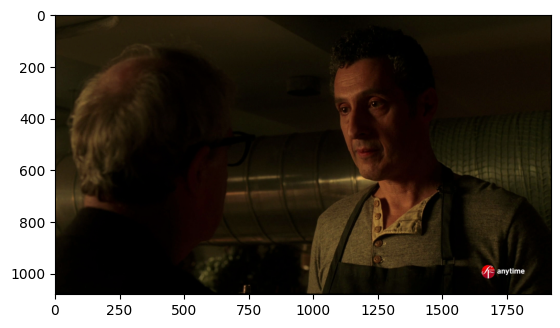

In [25]:
test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test"
random_video = random.choice(os.listdir(test))
print(random_video)

video_path = os.path.join(test, random_video)
print(video_path)

cap = cv2.VideoCapture(video_path)

cap_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(cap_length)

random_frame = random.randrange(0, cap_length)
print("printing frame number:", random_frame)

cap.set(cv2.CAP_PROP_POS_FRAMES, 1000) # frame 1000

ret, frame = cap.read()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # avoid frame becoming blue

if ret:
    plt.imshow(frame_rgb)
    plt.show()
    
cap.release()
cv2.destroyAllWindows()

In [78]:
# Rätt version av kompression
# runna inte igen
# compression_levels = [23, 50, 75]
compression = [23, 51]     # 51 är högsta

for video in os.listdir(train):
    video_path = os.path.join(train, video)
    if not os.path.isfile(video_path):
        continue                    # continue skips the current iteration if video_path is not a file, to the next iteration (instead of break that exits loop completely)
    
    # Choose a random compression level
    level = random.choice(compression_levels)
    
    # Construct the compressed file path
    compressed_filename = f"compressed_{level}_{video}"
    # ÄNDRA TILL f"{video}_compressed_{level}""
    compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2", compressed_filename)
    
    # Compress the video
    subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

    vmaf_command = [
        "ffmpeg",
        "-i", video_path,
        "-i", compressed_path,
        "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
        "-f", "null", "-"
    ]
    subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)



ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [9]:
# Kompression av testdata
# Runna inte igen
# compression_levels = [23, 50, 75]
compression_levels = [23, 51]

for video in os.listdir(test):
    video_path = os.path.join(test, video)
    if not os.path.isfile(video_path):
        continue                    # continue skips the current iteration if video_path is not a file, to the next iteration (instead of break that exits loop completely)
    
    # Choose a random compression level
    level = random.choice(compression_levels)
    
    # Construct the compressed file path
    compressed_filename = f"compressed_{level}_{video}"
    # ÄNDRA TILL f"{video}_compressed_{level}""
    compressed_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos", compressed_filename)
    
    # Compress the video
    subprocess.run(["ffmpeg", "-i", video_path, "-c:v", "libx264", "-crf", str(level), compressed_path])

    vmaf_command = [
        "ffmpeg",
        "-i", video_path,
        "-i", compressed_path,
        "-lavfi", f"[0:v][1:v]libvmaf=psnr=1:ssim=1:ms_ssim=1:log_fmt=json:log_path=vmaf_log_{level}_{video}.json",
        "-f", "null", "-"
    ]
    subprocess.run(vmaf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 12.0.0
  configuration: --prefix=/Users/ktietz/demo/mc3/conda-bld/ffmpeg_1628925491858/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=arm64-apple-darwin20.0.0-clang --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57

In [2]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train")))    
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2")))

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test")))    
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos")))


71
70
18
17


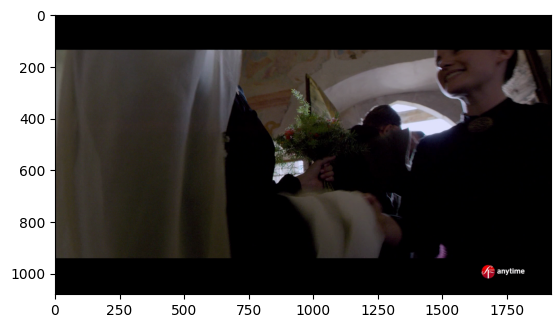

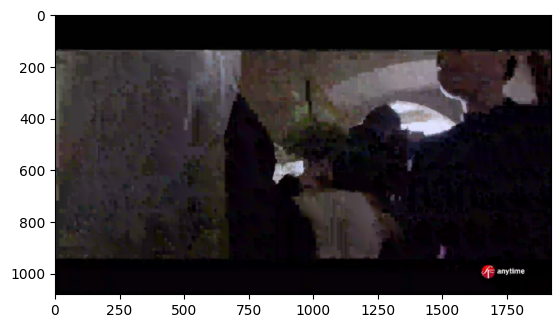

In [3]:
compressed_train = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data2"

video_path_0 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_0_a-hidden-life.mp4"
video_path_23 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_23_a-hidden-life.mp4"
video_path_50 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_50_a-hidden-life.mp4"
video_path_75 = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_data/compressed_75_a-hidden-life.mp4"
    
cap_0 = cv2.VideoCapture(video_path_0)
cap_75 = cv2.VideoCapture(video_path_75)

cap_0.set(cv2.CAP_PROP_POS_FRAMES, 1000)
cap_75.set(cv2.CAP_PROP_POS_FRAMES, 1000)

ret_0, frame_0 = cap_0.read()
frame_rgb_0 = cv2.cvtColor(frame_0, cv2.COLOR_BGR2RGB)   # avoid frame becoming blue

if ret_0:
    plt.imshow(frame_rgb_0)
    plt.show()
    
    
ret_75, frame_75 = cap_75.read()
frame_rgb_75 = cv2.cvtColor(frame_75, cv2.COLOR_BGR2RGB)   # avoid frame becoming blue

if ret_75:
    plt.imshow(frame_rgb_75)
    plt.show()
    

im_0 = Image.fromarray(frame_0)
im_75 = Image.fromarray(frame_75)
im_0.save("im0_TEST.png")
im_75.save("im75_TEST.png")

cap_0.release()
cap_75.release()
cv2.destroyAllWindows()

In [ ]:
# metadata över längd
# ta bort början och slut?
# hur långt kvar / 10s 
# frame rate?
# loopa ffmpeg

In [13]:
# kontrollera frames per second i datasetet

fps_list = []
for video in os.listdir(train):
    video_path = str(os.path.join(train, video))

    original_cap = cv2.VideoCapture(video_path)
    fps = int(original_cap.get(cv2.CAP_PROP_FPS))
    original_frame_count = int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps_list.append(fps)
    
    print(video_path, fps)
    original_cap.release()
    

print(min(fps_list))
print(max(fps_list))

/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-svart-fjaril.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/army-of-darkness.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wallander-forsvunnen.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-player.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/its-a-mad-mad-mad-mad-world.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-mothman-prophecies.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/road-house.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/knife-fight.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-alla-de-stillsamma-doda.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/tiny-tim-king-for-a-day.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/satans-slaves.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/silent-

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/the-road-to-wellville.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wish-upon.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/wheel-of-fortune-and-fantasy.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/maria-wern-drommen-forde-dig-vilse.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/bortom-tingri.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/son-of-a-gun.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/rocky-balboa.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/gone-in-60-seconds-1974.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/green-book.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/chitty-chitty-bang-bang.mp4 23
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/les-choses-quon-dit-les-choses-quon-fait.mp4 25
/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/traile

In [4]:
# dataset med bilder skapas
# kör inte igen
nr = 1

video_files = sorted(os.listdir(compressed_train))

for video in video_files:
    video_path = os.path.join(compressed_train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


In [7]:
# dataset med REFERENS-bilder skapas
# kör inte igen
nr = 1

video_files = sorted(os.listdir(train))

for video in video_files:
    video_path = os.path.join(train, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()


OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_train/.DS_Store"


In [26]:
# dataset med png-bilder skapas TESTSET
# kör inte igen

compressed_test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/compressed_TEST_videos"
nr = 1

video_files = sorted(os.listdir(compressed_test))

for video in video_files:
    video_path = os.path.join(compressed_test, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_compressed/TEST_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()

In [27]:
# dataset med REFERENS-bilder skapas TESTSET
# kör inte igen
nr = 1

video_files = sorted(os.listdir(test))

for video in video_files:
    video_path = os.path.join(test, video)
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    frameNr = 0
    
    while True:
        ret, frame = cap.read()
        
        if ret:
            if frameNr % 250 == 0:
                # Save every 250th frame
                cv2.imwrite(f'/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST/TEST_{nr}_{video}_frame{frameNr}.png', frame)
                nr += 1
        else:
            break
        
        frameNr += 1
    
    cap.release()

OpenCV: Couldn't read video stream from file "/Users/kajsalidin/Desktop/nr-vqa-vmaf/data/trailers_test/.DS_Store"


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_359_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_633_compressed_75_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png


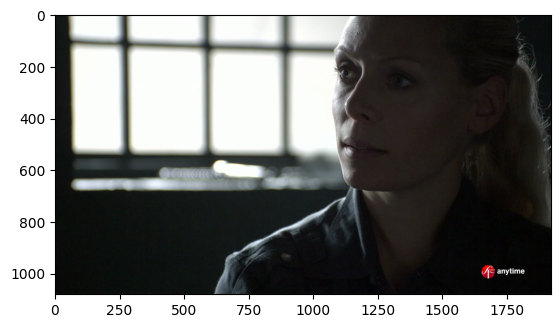

In [3]:
"""
VMAF
Algorithm:
1) Find all uncompressed frame versions. 
2) Remove frames that will not be used
3) Crop in a predetermined amount of patches, store in a new folder with descriptive names
4) loop through folder and calculate VMAF, store VMAF values in a new file 
"""


# göra cv2.COLOR_BGR2RGB på alla?
    

In [9]:
# Referens-frames CROP, träningsdata
# Runna inte igen!
input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png"
crop_size = (224, 224)   # default input size of DenseNet-121

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         # hur många kolumner i bilder
    num_chunks_y = height // crop_size[1]        # hur många rader

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   # mitten på bilden
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)

            """output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)"""

    im.close()


In [11]:
# komprimerade frames CROP, träningsdata
# Runna inte igen!
input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png"
crop_size = (224, 224)   # default input size of DenseNet-121

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         # hur många kolumner i bilder
    num_chunks_y = height // crop_size[1]        # hur många rader

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   # mitten på bilden
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)

            """output_filename = f"{os.path.splitext(filename)[0]}_{i}_{j}.jpg"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)"""

    im.close()

In [28]:
# komprimerade frames CROP, testdata
# Runna inte igen!

input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_compressed"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png"
crop_size = (224, 224)   # default input size of DenseNet-121

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         # hur många kolumner i bilder
    num_chunks_y = height // crop_size[1]        # hur många rader

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   # mitten på bilden
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)


    im.close()


In [29]:
# Referens-frames CROP, testdata
# Runna inte igen!
input_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST"
output_folder = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png"
crop_size = (224, 224)   # default input size of DenseNet-121

image_files = [f for f in os.listdir(input_folder) if f.endswith(('.png'))]

for filename in image_files:
    im_path = os.path.join(input_folder, filename)
    im = Image.open(im_path)
    width, height = im.size

    num_chunks_x = width // crop_size[0]         # hur många kolumner i bilder
    num_chunks_y = height // crop_size[1]        # hur många rader

    for i in range(0, num_chunks_x):
        for j in range(0, num_chunks_y):
            
            left = i * crop_size[0]
            top = j * crop_size[1]
            right = left + crop_size[0]
            bottom = top + crop_size[1]

            cropped = im.crop((left, top, right, bottom))
            
            location_info = ""
            if i == 0:
                location_info += "left_"
            elif i == num_chunks_x - 1:
                location_info += "right_"
            if j == 0:
                location_info += "top"
            elif j == num_chunks_y - 1:
                location_info += "bottom"
                
            if left <= 960 <= right and top <= 540 <= bottom:   # mitten på bilden
                location_info += "center_"
                
            
            pos_x = left
            pos_y = top
            
            output_filename = f"{os.path.splitext(filename)[0]}_{location_info}_start_{pos_x}_{pos_y}.png"
            output_path = os.path.join(output_folder, output_filename)
            cropped.save(output_path)


    im.close()

In [86]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png")))

print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png")))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png")))

25952
25952
5920
5920


(1080, 1920, 3)
start row 	-  540
end row 	-  764
start column 	-  540
end column 	-  764
(224, 224, 3)


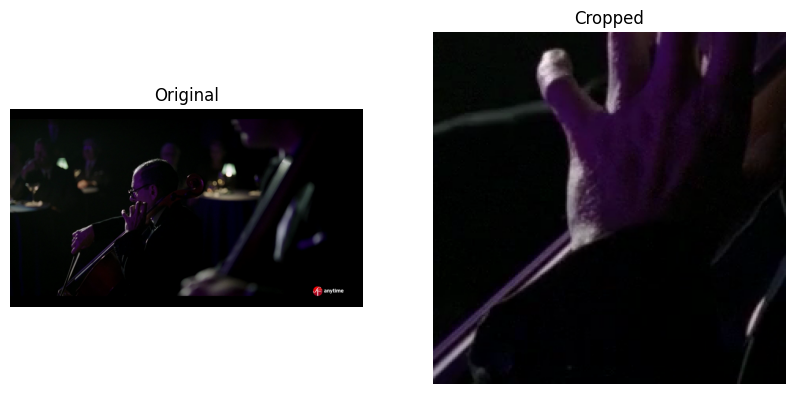

In [131]:
# test-tillämpning av crop, mitten-klippning, inte använd

image_shape = frame_rgb.shape

print(frame_rgb.shape)

# cropped_pieces = []

# imgwidth = frame_rgb.shape[0]
# imgheight = frame_rgb.shape[1]

length = 224
width = 224

start_row = 540
start_column = start_row

end_row = length + start_row

end_column = width + start_column

print("start row \t- ", start_row)
print("end row \t- ", end_row)
print("start column \t- ", start_column)
print("end column \t- ", end_column)

image_cropped = frame_rgb[start_row:end_row, start_column:end_column]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

ax1.axis("off")
ax1.title.set_text('Original')

ax2.axis("off")
ax2.title.set_text("Cropped")

ax1.imshow(frame_rgb)
ax2.imshow(image_cropped)

print(image_cropped.shape)     # (224, 224, 3)


In [165]:
reference_crops = []
compressed_crops = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png", image)
    
    reference_crops.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", image)
    
    compressed_crops.append(im_path)

def extract_details_ref(path):
    """
    Extracts movie name, frame number, and crop details from the path.
    """
    components = path.split("_")
    movie_name = components[5]
    frame_number = components[6]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def extract_details_comp(path):
    """
    Extracts movie name, frame number, and crop details from the path.
    """
    components = path.split("_")
    movie_name = components[8]
    frame_number = components[9]
    crop_details = "_".join(components[-2:])
    return movie_name, frame_number, crop_details


def sort_by_details_ref(path):
    """
    Sorts by movie name, frame number, and crop details.
    """
    movie_name, frame_number, crop_details = extract_details_ref(path)
    return movie_name, frame_number, crop_details


def sort_by_details_comp(path):
    """
    Sorts by movie name, frame number, and crop details.
    """
    movie_name, frame_number, crop_details = extract_details_comp(path)
    return movie_name, frame_number, crop_details


reference_sorted = sorted(reference_crops, key=sort_by_details_ref)
compressed_sorted = sorted(compressed_crops, key=sort_by_details_comp)

print(reference_sorted[45])
print(compressed_sorted[45])


/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_crop_png/train_5_a-hidden-life.mp4_frame1000_right__start_1568_224.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png/train_5_compressed_23_a-hidden-life.mp4_frame1000_right__start_1568_224.png


In [1]:
# test
one = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
two = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for int1, int2 in zip(one, two):
    print(int1)

1
2
3
4
5
6
7
8
9
10


In [51]:
"""
Kör command och skapa output för varje bild
VMAF terminal command:
ffmpeg-quality-metrics distorted.jpg reference.jpg --metrics vmaf

where ffmpeg

Python Subprocess:
From https://www.datacamp.com/tutorial/python-subprocess : 
It's like giving commands to your computer using Python instead of typing them directly into the command prompt. This module makes it easy to automate tasks and integrate other programs with your Python code.
This can be useful for tasks such as log analysis, data processing, and text manipulation.

https://github.com/Netflix/vmaf/issues/1168 : 
You need to prepare the input in YUV frame format (or use FFmpeg's filter chaining). 
When evaluating a single frame, VMAF will set the "motion" feature value to "0", meaning depriving of the motion masking effect from its estimation.

"""

"""def process_image(dist_im, ref_im):
    command = ['/opt/homebrew/bin/ffmpeg', '-i', dist_im, '-i', ref_im, '-lavfi', 'libvmaf', '-f', 'null', '-']
    # command = ['/opt/homebrew/bin/ffmpeg-quality-metrics', dist_im, ref_im, '--metrics', 'vmaf']
    output = subprocess.check_output(command)     # os.system()?
    return output.decode('utf-8')
    # output = os.system(f'ffmpeg-quality-metrics {dist_im} {ref_im} --metrics vmaf')
    
 
"""

output_file = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_train.csv" 
if len(reference_sorted) != len(compressed_sorted):
    print("Error: The number of files in the two folders is not the same.")
    exit()

vmaf_scores = []
count = 0
    
for filename1, filename2 in zip(reference_sorted, compressed_sorted):
        image_path_ref = filename1
        image_path_dist = filename2
        
        command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
        # out = subprocess.check_output(command, text=True) 
        # output = os.popen(f'/opt/homebrew/bin/ffmpeg -i {image_path_dist} -i {image_path_ref} -lavfi libvmaf=log_path=output.xml -f null -').read()
        output = subprocess.run(command, capture_output=True, text=True)
        # output = subprocess.Popen(command, stdout=subprocess.PIPE)
        """out = output.read()
        output.close()"""
        
        pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
        match = pattern.search(str(output))
        
        if match:
            vmaf_score = match.group(1)
            vmaf_scores.append([vmaf_score, image_path_dist])
            count +=1
        
        print(count)
        # break
            
            
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)
       
            
"""print(command)
print("----")

print("matches", match)
print("-----")
print(output)"""
# break

"""if match:
    vmaf_score = match.group(1)
    csv_writer.writerow([vmaf_score])"""
            
# print("VMAF scores written to:", output_file)     

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


'if match:\n    vmaf_score = match.group(1)\n    csv_writer.writerow([vmaf_score])'

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train/train_359_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2/train_633_compressed_75_maria-wern-alla-de-stillsamma-doda.mp4_frame1000.png


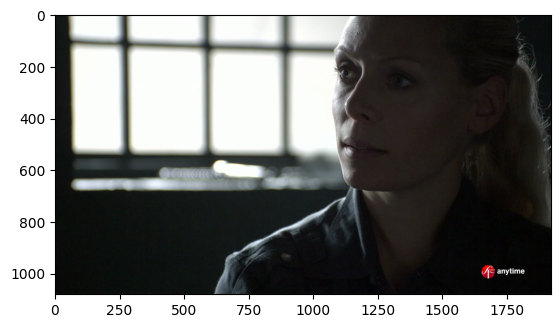

In [164]:
reference_frames = []
compressed_frames = []
# compressed_23 = []
# compressed_50 = []
# compressed_75 = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train", image)
    
    reference_frames.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_compressed2", image)
    
    compressed_frames.append(im_path)
        

def sort_by_movie_ref(path):
    return path.split("_")[3]    # filmnamn
   
def sort_by_movie_comp(path):
    # print(path.split("_")[6])
    return path.split("_")[6]     # filmnamn


def sort_by_frame(path):
    # print(path.split("_")[-1] )
    return path.split("_")[-1]         # bara nr


reference_sorted = sorted(reference_frames, key=sort_by_movie_ref)
compressed_sorted = sorted(compressed_frames, key=sort_by_movie_comp)

reference_sorted_by_frames = sorted(reference_sorted, key=sort_by_frame)
compressed_sorted_by_frames = sorted(compressed_sorted, key=sort_by_frame)


print(reference_sorted_by_frames[100])
print(compressed_sorted_by_frames[100])

plt.imshow(plt.imread(reference_sorted_by_frames[100]))  
# plt.imshow(plt.imread(compressed_sorted_by_frames[100])) 

In [58]:
# VMAF on full frames
output_file2 = "vmaf_on_full_frames_train.csv" 
ref = reference_sorted_by_frames
comp = compressed_sorted_by_frames
if len(ref) != len(comp):
    print("Error: The number of files in the two folders is not the same.")
    exit()

vmaf_scores = []
count = 0
    
for filename1, filename2 in zip(ref, comp):
        image_path_ref = filename1
        image_path_dist = filename2
        
        command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
        output = subprocess.run(command, capture_output=True, text=True)
    
        pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
        match = pattern.search(str(output))
        
        if match:
            vmaf_score = match.group(1)
            vmaf_scores.append([vmaf_score, image_path_dist])
            count +=1
        
        print(count)
        # break
            
            
with open(output_file2, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


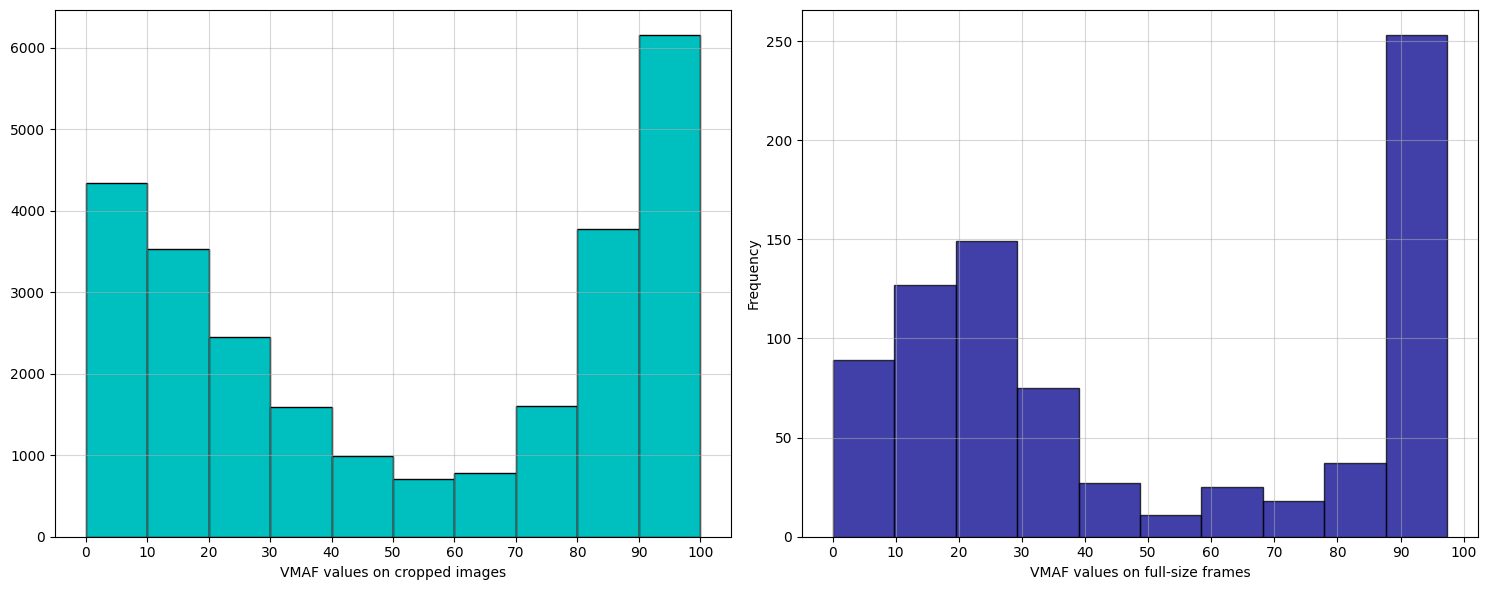

In [86]:
"""
Här ska vi köra lite analyser, titta på distributionen av VMAF för olika ställen i bilden. 

- Kolla på medelvärde och standardavvikelse bland olika delar i bilden
- Probability distribution
"""

file = pd.read_csv("vmaf_values_train.csv")
# print(file.iloc[:, 0])

file2 = pd.read_csv("vmaf_on_full_frames_train.csv")

# s = pd.Series(file.iloc[:, 0])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(file.iloc[:, 0], edgecolor="k", color="c")
axs[0].grid(alpha=0.5)
axs[0].set_xlabel("VMAF values on cropped images")
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(file2.iloc[:, 0], edgecolor="k", color="darkblue", alpha=0.75)
axs[1].set_xlabel("VMAF values on full-size frames")
axs[1].set_ylabel('Frequency')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()



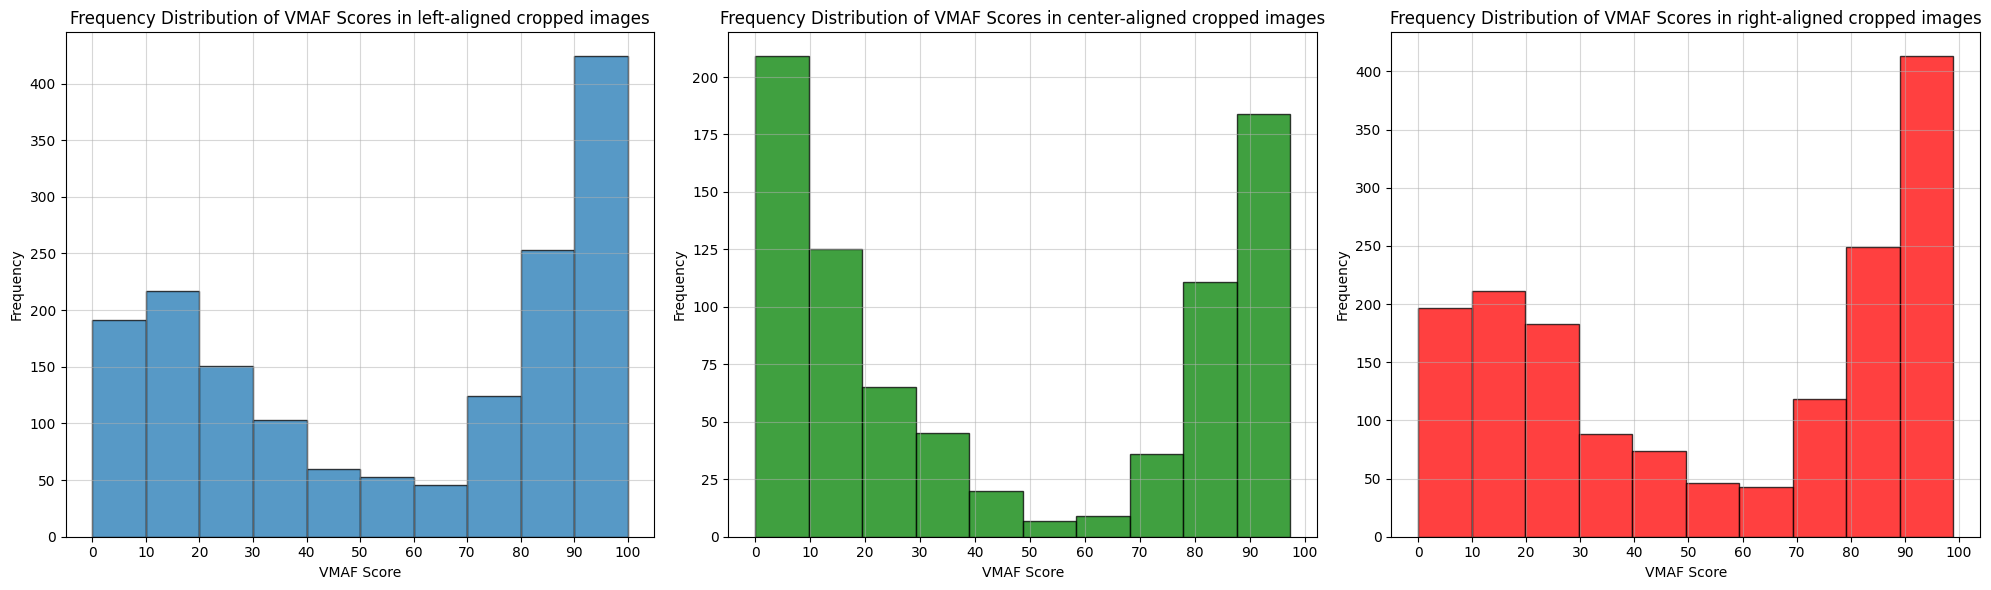

In [72]:
csv_file_path = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_train.csv"

positions = []
left = []
right = []
bottom = []
top = []
center = []
corners = []

with open(csv_file_path, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    for row in csv_reader:
        vmaf_score = row[0]
        filename = row[1]
        
        position_info = filename.split('/')[-1].split('_')[6:-1]
        position = [vmaf_score, '_'.join(position_info)]
        positions.append(position)
        
        
    for pos in positions:
        if "center" in str(pos[1]):
            center.append(pos)
            
        elif "top" in str(pos[1]):
            top.append(pos)
            
            if "left" or "right" in str(pos[1]):
                corners.append(pos)
            
        elif "bottom" in str(pos[1]):
            bottom.append(pos)
            
            if "left" or "right" in str(pos[1]):
                corners.append(pos)
        
            
        elif "right" in str(pos[1]):
            right.append(pos)
            
        elif "left" in str(pos[1]):
            left.append(pos)
            
    # print(positions)

vmaf_left = [float(item[0]) for item in left]
vmaf_right = [float(item[0]) for item in right]
vmaf_center = [float(item[0]) for item in center]

# print(sorted(vmaf_left))

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(sorted(vmaf_left), edgecolor="k", alpha=0.75)
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of VMAF Scores in left-aligned cropped images')
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(vmaf_center), edgecolor="k", color="g", alpha=0.75)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of VMAF Scores in center-aligned cropped images')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

axs[2].hist(sorted(vmaf_right), edgecolor="k", color="r", alpha=0.75)
axs[2].set_xlabel('VMAF Score')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Frequency Distribution of VMAF Scores in right-aligned cropped images')
axs[2].set_xticks(range(0, 101, 10))
axs[2].grid(alpha=0.5)

plt.tight_layout()
plt.show()

        

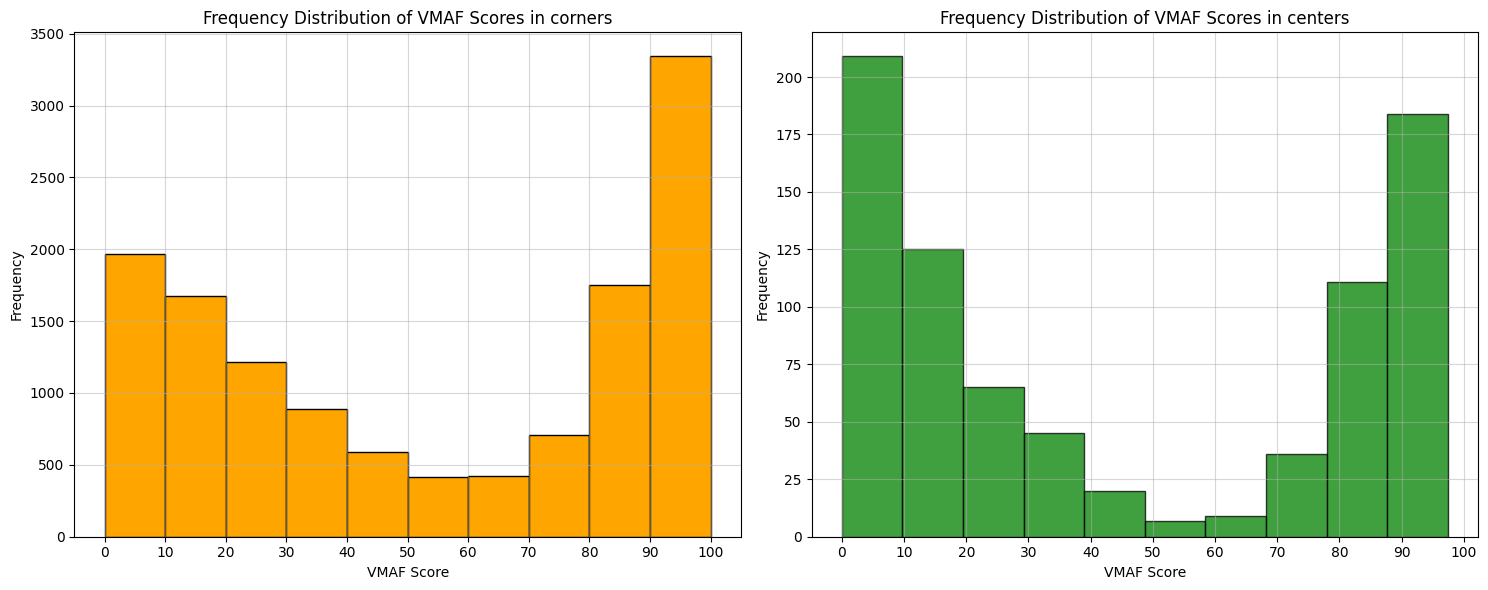

In [82]:
# print(corners)
vmaf_corners = [float(item[0]) for item in corners]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(sorted(vmaf_corners), color = "orange", edgecolor="k")
axs[0].set_xlabel('VMAF Score')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Frequency Distribution of VMAF Scores in corners')    # corners include left bottom, left top, right bottom, right top
axs[0].set_xticks(range(0, 101, 10))
axs[0].grid(alpha=0.5)

axs[1].hist(sorted(vmaf_center), color = "green", edgecolor="k", alpha=0.75)
axs[1].set_xlabel('VMAF Score')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Frequency Distribution of VMAF Scores in centers')
axs[1].set_xticks(range(0, 101, 10))
axs[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()


In [56]:
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png")))
df = pd.read_csv('vmaf_values_train.csv')
print(df.shape[0])      

25952
25952


In [172]:
reference_crops_test = []
compressed_crops_test = []

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png", image)
    
    reference_crops_test.append(im_path)

for image in os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png"):
    im_path = os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png", image)
    
    compressed_crops_test.append(im_path)



reference_sorted_test = sorted(reference_crops_test, key=sort_by_details_ref)
compressed_sorted_test = sorted(compressed_crops_test, key=sort_by_details_comp)

print(reference_sorted_test[45])
print(compressed_sorted_test[45])
"""print(len(reference_sorted_test))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png")))
print(len(compressed_sorted_test))
print(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png")))"""

/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png/TEST_5_agent-cody-banks.mp4_frame1000_right__start_1568_224.png
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png/TEST_5_compressed_23_agent-cody-banks.mp4_frame1000_right__start_1568_224.png


'print(len(reference_sorted_test))\nprint(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_crop_png")))\nprint(len(compressed_sorted_test))\nprint(len(os.listdir("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_TEST_comp_crop_png")))'

In [173]:
# VMAF värden TEST-set
output_file_test = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/vmaf_values_TEST.csv" 
ref = reference_sorted_test
comp = compressed_sorted_test
if len(ref) != len(comp):
    print("Error: The number of files in the two folders is not the same.")
    exit()

vmaf_scores = []
count = 0
    
for filename1, filename2 in zip(ref, comp):
        image_path_ref = filename1
        image_path_dist = filename2
        
        command = ['/opt/homebrew/bin/ffmpeg', '-i', image_path_dist, '-i', image_path_ref, '-lavfi', 'libvmaf', '-f', 'null', '-']
        output = subprocess.run(command, capture_output=True, text=True)
    
        pattern = re.compile(r'VMAF score: (\d+\.\d+)')  # (\d+\.\d+) matches the VMAF score
        match = pattern.search(str(output))
        
        if match:
            vmaf_score = match.group(1)
            vmaf_scores.append([vmaf_score, image_path_dist])
            count +=1
        
        print(count)
        # break
            
            
with open(output_file_test, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['VMAF Score', 'Filename'])
    csv_writer.writerows(vmaf_scores)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


29.437398
/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png/train_599_compressed_75_knives-out.mp4_frame3250_top_start_1344_0.png


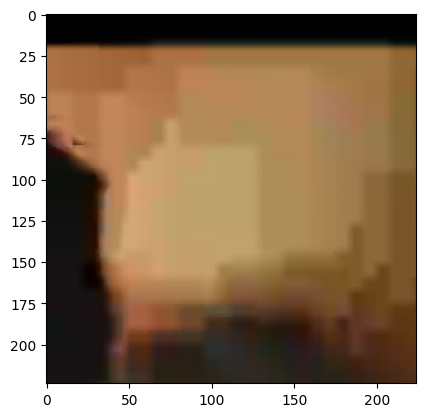

In [148]:
print(pd.read_csv("vmaf_values_train.csv").iloc[9000, 0])
print(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", pd.read_csv("vmaf_values_train.csv").iloc[9000, 1]))
plt.imshow(mpimg.imread(os.path.join("/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", pd.read_csv("vmaf_values_train.csv").iloc[9000, 1])))

In [5]:
# Bra länk: https://discuss.pytorch.org/t/class-dataset-concatenating-labels-with-the-corresponding-images/85762 
# Från: https://pandas.pydata.org/docs/user_guide/merging.html 

# concat(): Merge multiple Series or DataFrame objects along a shared index or column, inte riktigt rätt. Kanske join="outer"
# merge(): Combine two Series or DataFrame objects with SQL-style joining
# merge_ordered(): Combine two Series or DataFrame objects along an ordered axis
# Series.compare() and DataFrame.compare(): Show differences in values between two Series or DataFrame objects 

class ImagesAndLabelsDataset(Dataset): 
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)      # labels
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = self.annotations.iloc[index, 1]
        try:
            image = mpimg.imread(img_path)
        except Exception as e:
            print(f"Error reading image at index {index}: {e}")
            return None
        y_label = torch.tensor(self.annotations.iloc[index, 0], dtype=torch.float32)    # VMAF score
        norm = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])   # normalisering från https://pytorch.org/hub/pytorch_vision_densenet/
        
        if self.transform:
            image = self.transform(image)
            norm(image)
            # image.unsqueeze(0)
        
            
        return (image, y_label)
    
    
data = ImagesAndLabelsDataset(csv_file = "vmaf_values_train.csv", root_dir = "/Users/kajsalidin/Desktop/nr-vqa-vmaf/images_train_comp_crop_png", transform = transforms.ToTensor())
train_set, val_set = torch.utils.data.random_split(data, [0.9, 0.1])      # 10% validation [0.95, 0.05]
train_loader = DataLoader(dataset=train_set, shuffle=False)
val_loader = DataLoader(dataset=val_set, shuffle=False)

# Data loader combines a dataset and a sampler, and provides an iterable over the given dataset, easy access to the sampöes

"""
To train DenseNet on train data:
1) loop over epochs (passes in dataset)
2) loop over minibatches
3) forward pass
4) compute loss
5) backward pass
6) upgrade parameters with optimizer (Adam)

"""
    

'\nTo train DenseNet on train data:\n1) loop over epochs (passes in dataset)\n2) loop over minibatches\n3) forward pass\n4) compute loss\n5) backward pass\n6) upgrade parameters with optimizer (Adam)\n\n'

In [17]:
# validation set? 
# train_data.__len__()
val_set.__len__()
# train_data[9000]      # vmaf values as torch.float32

2595

In [388]:
# TEST
# Input: (16, 3, 224, 224)
# output from conv2D: (16, 64, 112, 112) Height and width are reduced due to the convolution operation (halved because of stride 2).
# Flatten:
# Input: (16, 64, 112, 112), Output: (16, 802816)
# Linear Layer (nn.Linear): nn.Linear(1024, 1)
# Input: (16, 802816)
# Output: (16, 1)


preloaded = models.densenet121(pretrained=True)
print(len(preloaded.features))
conv0  = nn.Conv2d(3, 64, 7, 2, 3)

for param in preloaded.parameters():  # Freeze all parameters in self.features
            param.requires_grad = False
             
classifier = nn.Linear(1024, 1)     # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
# sista lagret avgör så att det blir regression.
        
for param in classifier.parameters():     # unfreeza sista lagret
    param.requires_grad = True
    
# print(preloaded.features(torch.randn(1, 3, 224, 224)))
# print(len(preloaded.features(torch.randn(16, 3, 224, 224)))) 16 
# print(len(F.relu(preloaded.features(torch.randn(16, 3, 224, 224)), inplace=True))) 16
print(preloaded.features(torch.flatten(F.relu(preloaded.features(torch.randn(16, 3, 224, 224)), inplace=True))))  # 802816
# print(nn.Linear(F.relu(preloaded.features(torch.randn(16, 3, 224, 224)), inplace=True), 1024))
# print(nn.Linear((16, 802816), (16,1024)))
    
"""def forward(x):
        print(len(preloaded.features(x)))
        out = F.relu(features, inplace=True)     # activation function, A rectified linear unit (ReLU) is an activation function that introduces the property of non-linearity to a deep learning model and solves the vanishing gradients issue.
        # out = F.adaptive_avg_pool2d(out, (1, 1))  # Global average pooling, torch.nn.functional.adaptive_avg_pool2d(input, output_size). Tuple.
        out = torch.flatten(out, 1)        # Flattens input by reshaping it into a one-dimensional tensor, behövs både flatten och global average pooling?
        out = nn.Linear(out) 
        out = classifier(out)
        return out.squeeze(1)"""

12


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [802816]

In [13]:
# Från https://www.kaggle.com/code/leighplt/densenet121-pytorch
# Kolla lite på denna för memory efficient network: https://github.com/gpleiss/efficient_densenet_pytorch/blob/master/models/densenet.py
# X_train is the instance with attributes, y_train is the label of each instance
# output layer ska vara anpassat för regression istället för classes
# Single neuron for regression
# loss function: typ MSE
# inget softmax activation function
# efficient=True

class DenseNet(nn.Module):
    def __init__(self, num_channels=3):      # Inga num_classes eftersom ej klassifikation. num_channels=6 i exempelkod men kanske ska skicka in 3??
        super().__init__()
        preloaded = models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)   # in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None
        """
        Including a bias term allows the model to learn a better representation of the data by shifting the activation function's output. 
        It effectively adds flexibility to the model's decision boundary, allowing it to fit more complex patterns in the data.
        """
        for param in self.features.parameters():  # Freeze all parameters in self.features
            param.requires_grad = False
           
        self.dense = nn.Linear(50176, 1024)    # 224 * 224 * 3 = 37632  
        self.dense2 = nn.Linear(1024, 1024)
        self.dense3 = nn.Linear(1024, 1024)
        self.dense4 = nn.Linear(1024, 1024)
        self.dense5 = nn.Linear(1024, 1024)
        self.classifier = nn.Linear(1024, 1)     # torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        # self.dense = nn.Linear(802816, 1024)
        # 50176 är från error RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x50176 and 37632x1024)
        # sista lagret avgör så att det blir regression.
        
        for param in self.dense.parameters():
            param.requires_grad = True
            
        for param in self.dense2.parameters():
            param.requires_grad = True
            
        for param in self.dense3.parameters():
            param.requires_grad = True
            
        for param in self.dense4.parameters(): 
            param.requires_grad = True
            
        for param in self.dense5.parameters(): 
            param.requires_grad = True
        
        for param in self.classifier.parameters():     # unfreeza sista lagret
            param.requires_grad = True
            
        
    def forward(self, x):
        features = self.features(x)       # hidden layers, feature maps
        out = F.relu(features, inplace=True)     # activation function, A rectified linear unit (ReLU) is an activation function that introduces the property of non-linearity to a deep learning model and solves the vanishing gradients issue.
        out = torch.flatten(out, 1)        # Flattens input by reshaping it into a one-dimensional tensor, from second dimension of input tensor
        out = self.dense(out)    # måste bli en tensor?
        # out = self.features(out)  
        out = F.relu(out, inplace=True)
        out = self.dense2(out)
        out = F.relu(out, inplace=True)
        out = self.dense3(out)
        out = F.relu(out, inplace=True)
        out = self.dense4(out)
        out = F.relu(out, inplace=True)
        out = self.dense5(out)
        out = F.relu(out, inplace=True)
        out = self.classifier(out)
        return out.squeeze(1)  # Ensure output is a 1D tensor, reduce array dimensionality, removes axis of length 1
    # kanske ta bort squeeze
    
    #  linear(): argument 'input' (position 1) must be Tensor, not Linear
    
    # Dense-lager (fc) eller max pooling istället för avg pooling
    # för många lager
    # Avg pooling smetar ut signalen men är billig
    
    # dropout and batch_norm?
    # regressionLayer?

In [20]:
# Train model, från https://www.kaggle.com/code/leighplt/densenet121-pytorch

# model = DenseNet(num_classes=classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16    # testa runt lite
model = DenseNet(num_channels=3)

model.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

# testa sänka från 0.001 till 10^-5 till 0.000001 till 1
# lr explosion test

In [57]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inp

In [21]:
model.train()     # model.train() tells your model that you are training the model
num_epochs = 5   # ca 5
for epoch in range(num_epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        if i >= 2500:
            break
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # parameter gradients to zero?
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:    # varje 100onde mini-batch
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        
        """running_loss += loss.item()
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0"""

print('Done')

[1,   100] loss: 3271.122
[1,   200] loss: 1396.129
[1,   300] loss: 1476.615
[1,   400] loss: 1183.279
[1,   500] loss: 1275.997
[1,   600] loss: 1100.521
[1,   700] loss: 1326.644
[1,   800] loss: 1215.280
[1,   900] loss: 1314.911
[1,  1000] loss: 1166.143
[1,  1100] loss: 1146.250
[1,  1200] loss: 1079.558
[1,  1300] loss: 1212.001
[1,  1400] loss: 1072.466
[1,  1500] loss: 1275.630
[1,  1600] loss: 1149.018
[1,  1700] loss: 1014.910
[1,  1800] loss: 1468.403
[1,  1900] loss: 961.385
[1,  2000] loss: 1291.112
[1,  2100] loss: 1292.454
[1,  2200] loss: 1114.096
[1,  2300] loss: 1096.553
[1,  2400] loss: 1026.615
[1,  2500] loss: 916.574
[2,   100] loss: 1095.487
[2,   200] loss: 562.306
[2,   300] loss: 841.490
[2,   400] loss: 607.619
[2,   500] loss: 649.213
[2,   600] loss: 599.060
[2,   700] loss: 600.668
[2,   800] loss: 621.909
[2,   900] loss: 742.659
[2,  1000] loss: 685.523
[2,  1100] loss: 650.781
[2,  1200] loss: 795.977
[2,  1300] loss: 731.232
[2,  1400] loss: 611.789
[

In [ ]:
"""new_model_instance = DenseNet(num_channels=3)

new_model_instance.to(device)

criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  """

In [22]:
model.eval() 

num_epochs = 5   


for epoch in range(num_epochs):
    running_loss = 0.0
    
    # with torch.no_grad():
    
    for i, data in enumerate(val_loader, 0):
        """if i >= 10000:
            break"""
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # parameter gradients to zero?
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        """print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0"""
        
        if i % 25 == 24:    # varje 25:e mini-batch
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
    
print('Done')

[1,    25] loss: 350.579
[1,    50] loss: 193.167
[1,    75] loss: 214.551
[1,   100] loss: 114.713
[1,   125] loss: 329.669
[1,   150] loss: 264.196
[1,   175] loss: 269.617
[1,   200] loss: 283.601
[1,   225] loss: 356.615
[1,   250] loss: 206.890
[1,   275] loss: 209.235
[1,   300] loss: 317.954
[1,   325] loss: 255.688
[1,   350] loss: 171.269
[1,   375] loss: 207.487
[1,   400] loss: 346.376
[1,   425] loss: 152.228
[1,   450] loss: 170.594
[1,   475] loss: 116.053
[1,   500] loss: 193.284
[1,   525] loss: 164.298
[1,   550] loss: 174.443
[1,   575] loss: 242.184
[1,   600] loss: 230.937
[1,   625] loss: 280.588
[1,   650] loss: 194.269
[1,   675] loss: 220.017
[1,   700] loss: 169.880
[1,   725] loss: 211.544
[1,   750] loss: 321.520
[1,   775] loss: 207.939
[1,   800] loss: 222.835
[1,   825] loss: 238.724
[1,   850] loss: 158.892
[1,   875] loss: 284.925
[1,   900] loss: 245.532
[1,   925] loss: 200.392
[1,   950] loss: 287.426
[1,   975] loss: 151.968
[1,  1000] loss: 182.683


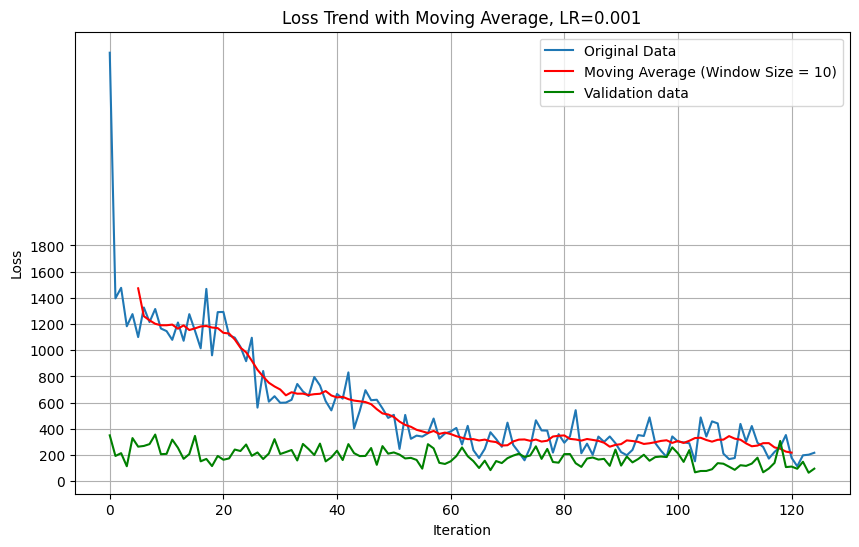

'plt.plot(losses)\nplt.xticks(range(0, 100, 20))\n# plt.yticks(range(0, 2050, 200))\nplt.title("Losses over 1 epoch, 100 values")\nf.close()'

In [29]:
# Losses over 3 epoch, 50 values from 5,000 first vals

losses = []
validation = []
num = 0
with open ("output_training_losses_test_0.001LR.txt", 'r') as f:
    for line in f: 
        losses.append(float(line.split()[-1]))
        

with open("/Users/kajsalidin/Desktop/nr-vqa-vmaf/output_val_losses_0.001LR.txt", "r") as f2:
    for line2 in f2:
        validation.append(float(line2.split()[-1]))
        


window_size = 10
# Calculate the moving average using np.convolve
moving_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

# Calculate the indices for plotting
indices = np.arange(window_size//2, len(losses) - window_size//2 + 1)
# print(len(indices))

# Plot the original data and the smoothed data
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Original Data')
plt.plot(indices, moving_avg, color='red', label=f'Moving Average (Window Size = {window_size})')
plt.plot(validation[0:125], label= "Validation data", color="g")
# plt.xticks(range(0, 150, 10))
plt.yticks(range(0, 2000, 200))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Trend with Moving Average, LR=0.001')
plt.legend()
plt.grid(True)
plt.show()
        

"""plt.plot(losses)
plt.xticks(range(0, 100, 20))
# plt.yticks(range(0, 2050, 200))
plt.title("Losses over 1 epoch, 100 values")
f.close()"""

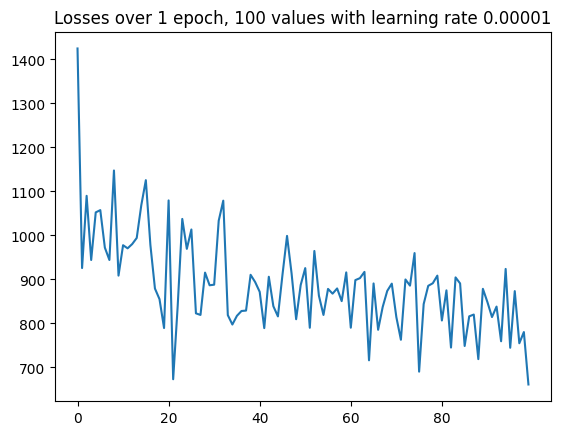

In [20]:
# Losses over 1 epoch, 100 values from 10,000 first vals with learning rate 0.00001
# hundred_vals_slow_lr_rate.png
losses = []
num = 0
with open ("output_training_losses_test.txt", 'r') as f:
    for line in f: 
        losses.append(float(line.split()[-1]))
        

plt.plot(losses)
plt.xticks(range(0, 100, 20))
# plt.yticks(range(0, 2050, 200))
plt.title("Losses over 1 epoch, 100 values with learning rate 0.00001")
f.close()

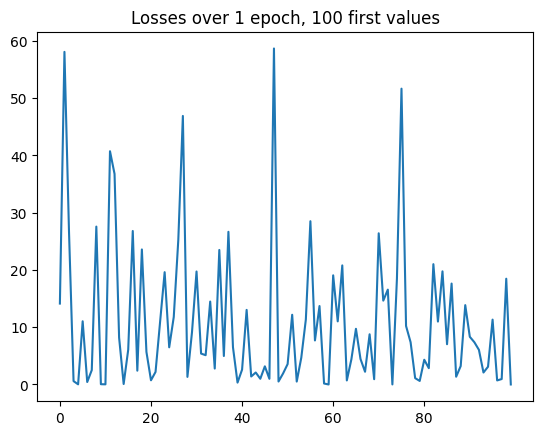

In [408]:
losses = []
num = 0
with open ("output_training_losses_test.txt", 'r') as f:
    for line in f: 
        losses.append(float(line.split()[-1]))
        

plt.plot(losses)
plt.xticks(range(0, 100, 20))
# plt.yticks(range(500, 3000, 1000))
plt.title("Losses over 1 epoch, 100 first values")
f.close()

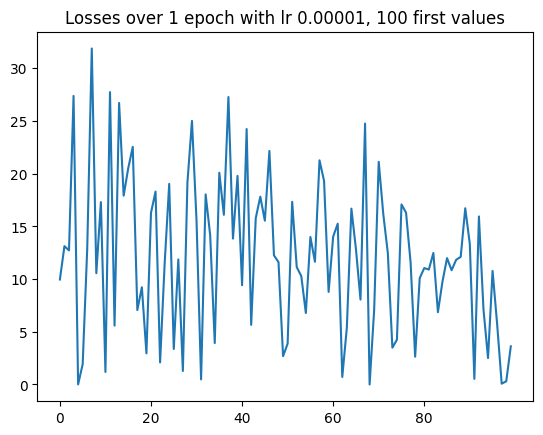

In [413]:
losses = []
num = 0
with open ("output_training_losses_test.txt", 'r') as f:
    for line in f: 
        losses.append(float(line.split()[-1]))
        

plt.plot(losses)
plt.xticks(range(0, 100, 20))
# plt.yticks(range(500, 3000, 1000))
plt.title("Losses over 1 epoch with lr 0.00001, 100 first values")
f.close()

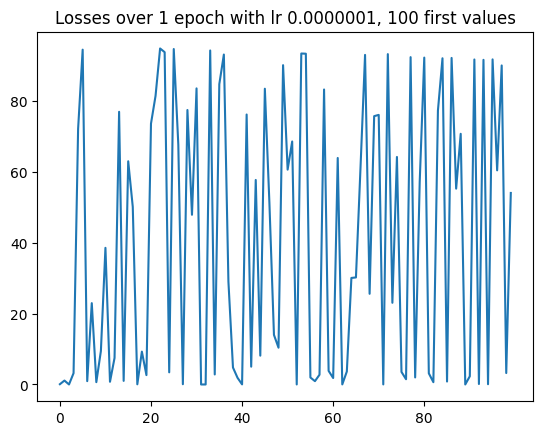

In [416]:
losses = []
num = 0
with open ("output_training_losses_test.txt", 'r') as f:
    for line in f: 
        losses.append(float(line.split()[-1]))
        

plt.plot(losses)
plt.xticks(range(0, 100, 20))
# plt.yticks(range(500, 3000, 1000))
plt.title("Losses over 1 epoch with lr 0.0000001, 100 first values")
f.close()

Text(0.5, 1.0, 'Losses over 5 epoch, lr 0.001 and 10 values/epoch, no avg pooling')

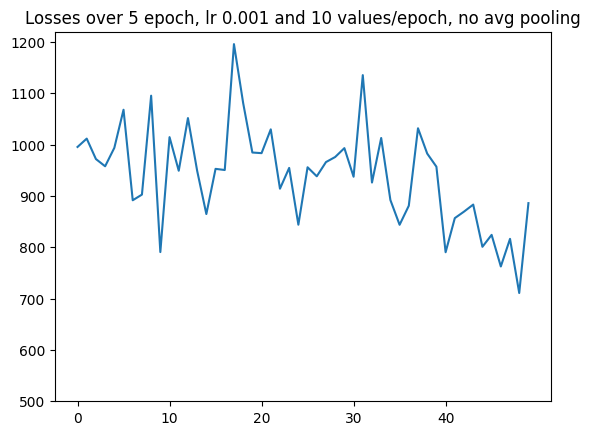

In [286]:
losses2 = [995.266,1011.487,971.730,957.639,993.533,1067.698,891.471,902.463,1095.122,790.564,1014.420,948.943,1051.550,
948.934,864.594,952.616,950.385,1195.529,1080.774,984.450,983.208,1029.552,913.988,954.450,843.866,955.725,938.139,965.833,
975.707,992.971,937.279,1135.168,926.017,1012.773,891.928,843.690,880.778,1031.676,982.406,956.834,790.233,856.682,869.340,
883.043,800.830,824.078,762.525,816.303,710.839,885.878]

plt.plot(losses2)
    
plt.xticks(range(0, 50, 10))
plt.yticks(range(500, 1300, 100))

plt.title("Losses over 5 epoch, lr 0.001 and 10 values/epoch, no avg pooling")


In [ ]:
# från https://www.kaggle.com/code/leighplt/densenet121-pytorch
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return np.array(res)

In [ ]:
# från https://www.kaggle.com/code/leighplt/densenet121-pytorch
epochs = 10
tlen = len(train_loader)        # loader = D.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=2)
for epoch in range(epochs):
    tloss = 0
    acc = np.zeros(1)
    for x, y in train_loader: 
        x = x.to(device)
        optimizer.zero_grad()
        output = model(x)
        target = torch.zeros_like(output, device=device)
        target[np.arange(x.size(0)), y] = 1
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tloss += loss.item() 
        acc += accuracy(output.cpu(), y)
        del loss, output, y, x, target
    print('Epoch {} -> Train Loss: {:.4f}, ACC: {:.2f}%'.format(epoch+1, tloss/tlen, acc[0]/tlen))

In [ ]:
# Prediction for test, från https://www.kaggle.com/code/leighplt/densenet121-pytorch

@torch.no_grad()          # no gradients
def prediction(model, loader):
    preds = np.empty(0)
    for x, _ in loader: 
        x = x.to(device)
        output = model(x)
        idx = output.max(dim=-1)[1].cpu().numpy()
        preds = np.append(preds, idx, axis=0)
    return preds

preds = prediction(model, tloader)      # tloader är test loader


In [ ]:
# Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task.

"""
model.eval() is a kind of switch for some specific layers/parts of the model that behave differently 
during training and inference (evaluating) time. For example, Dropouts Layers, BatchNorm Layers etc.  
You need to turn them off during model evaluation, and .eval() will do it for you.
In addition, the common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation:
"""

model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# model.eval()    # BUT, don't forget to turn back to training mode after eval step: model.train()